In [1]:
import numpy as np

from baseline import baseline
from sample import sample
from normalization import normalization

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.decomposition import NMF

ModuleNotFoundError: No module named 'baseline'

In [69]:
image = np.load('image2.npy')

32x32 sample image

In [85]:
im = sample(image, 32)

In [108]:
np.amin(im)

-0.017947311119366923

In [109]:
im -= np.amin(im)
im /= np.amax(im)

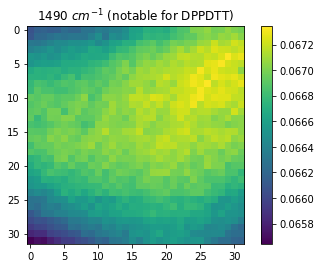

In [110]:
plt.imshow(im[:,:,1490-750])
plt.colorbar()
plt.title('1490 $cm^{-1}$ (notable for DPPDTT)')
plt.show()

Instantiate model with hyperparameters

In [111]:
nmf = NMF(n_components = 2, solver = 'cd', tol = 1e-5, max_iter=int(1e6), l1_ratio = 0.2, alpha = 1e-3, random_state = 0, verbose = False)

Flatten image

In [112]:
im2d = np.zeros((im.shape[0]**2, im.shape[2]))
for i in range(im.shape[2]):
    im2d[:,i] = im[:,:,i].flatten()

In [113]:
im2d.shape

(1024, 1128)

Run the fit function!

In [128]:
W_mat = nmf.fit_transform(X = im2d + abs(np.min(im2d)))

In [129]:
H_mat = nmf.components_

for i in range(H_mat.shape[0]):
    base_i = baseline(H_mat[i,:])
    H_mat[i,:] = H_mat[i,:] - base_i

In [131]:
H_mat[0,:] = np.interp(H_mat[0,:], (H_mat[0,:].min(), H_mat[0,:].max()), (0,1))
H_mat[1,:] = np.interp(H_mat[1,:], (H_mat[1,:].min(), H_mat[1,:].max()), (0,1))

Let's check how the components compare to the ground truths

In [133]:
ps = np.load('ps_ground_truth.npy')
dppdtt = np.load('dppdtt_ground_truth.npy')

# normalize ground truths
ps = np.interp(ps, (ps.min(), ps.max()), (0,1))
dppdtt = np.interp(dppdtt, (dppdtt.min(), dppdtt.max()), (0,1))

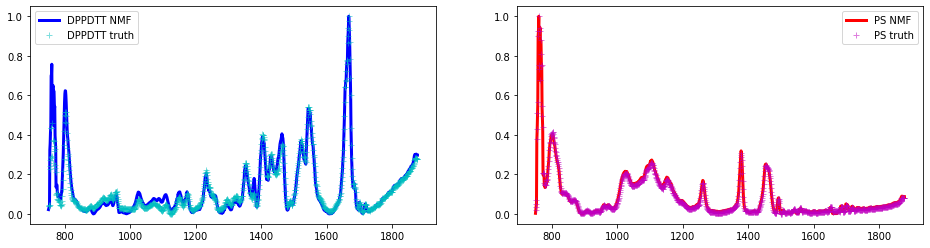

In [134]:
fig, ax = plt.subplots(ncols = 2, figsize = (16,4))
x = np.arange(750, 1878)
ax[0].plot(x, H_mat[0,:], label = 'DPPDTT NMF', color = 'blue', linewidth = 3)
ax[0].plot(x, dppdtt, 'c+', alpha = 0.5, label = 'DPPDTT truth')
ax[0].legend()

ax[1].plot(x, H_mat[1,:], label = 'PS NMF', color = 'red', linewidth = 3)
ax[1].plot(x, ps, 'm+', alpha = 0.5, label = 'PS truth')
ax[1].legend()

plt.show()

RMSE will tell us how well the NMF did when decomposing the image.

In [135]:
from sklearn.metrics import mean_squared_error as mse # make variable squared = False for root mean squared error

In [136]:
dppdtt_rmse = mse(dppdtt, H_mat[0,:], squared = False)
ps_rmse = mse(ps, H_mat[1,:], squared = False)

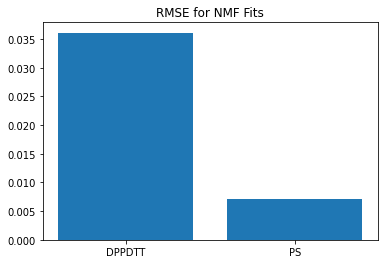

In [137]:
plt.bar([0.5, 1.5],[dppdtt_rmse, ps_rmse])
plt.xticks([0.5,1.5], ['DPPDTT', 'PS'])
plt.title('RMSE for NMF Fits')
plt.show()

Let's look at the coefficient matrices. First, reshape the W matrix.

In [145]:
W_mat.shape

(1024, 2)

In [143]:
coefficients = W_mat.reshape((32,32,2))

Text(0.5, 1.0, 'PS Coefficients')

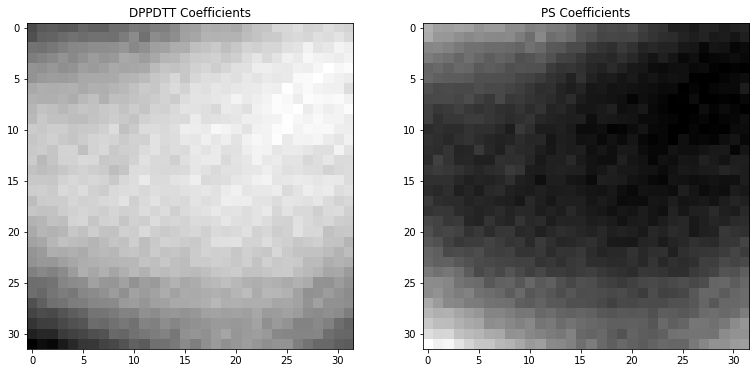

In [123]:
fig, ax = plt.subplots(ncols = 2, figsize = (13,6))

ax[0].imshow(coefficients[:,:,0], cmap = 'gray')
ax[0].set_title('DPPDTT Coefficients')

ax[1].imshow(coefficients[:,:,1], cmap = 'gray')
ax[1].set_title('PS Coefficients')

**We shouldn't normalize the coefficients to reconstruct the image. We can do that later when we want to threshhold the image to identify regions that are mostly PS or mostly DPPDTT.**

Reconstruction = W x H

In [167]:
result = np.matmul(W_mat, H_mat)

In [168]:
result.shape

(1024, 1128)

In [169]:
result = result.reshape((32,32,1128))

This time, I chose a less ambiguous wavelength. Both DPPDTT and PS contain peaks at 1490 wavenumbers, while only DPPDTT has a peak at 1550 wavenumbers. We should try plotting ambiguous wavenumbers with the same colorbar scale to emphasize that any "inverted" looking color scheme is in fact a fraction of the original image's contrast.

Text(0.5, 1.0, 'Reconstructed Image')

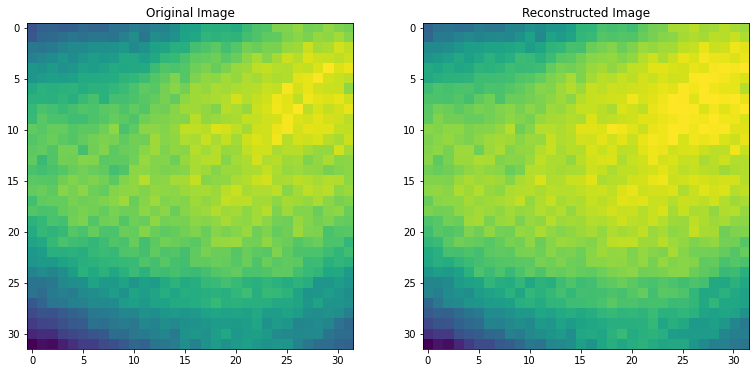

In [170]:
fig, ax = plt.subplots(ncols = 2, figsize = (13,6))

ax[0].imshow(im[:,:,1550-750])
ax[0].set_title('Original Image')

ax[1].imshow(result[:,:,1550-750])
ax[1].set_title('Reconstructed Image')

Thoughts on identifying regions of DPPDTT/PS:
- take two coefficients matrices:
    - for each pixel, divide each pixel by the sum of the coefficients at that pixel
    - results in 2 matrices where the corresponding pixels should sum to 1

if DPPDTT(0,0) = 0.4, PS(0,0) = 0.1, then resultDPPDTT(0,0) = 0.4/0.5 and resultPS(0,0) = 0.1/0.5

Then, we can identify the regions that are mostly PS or mostly DPPDTT with one of the result coefficient matrices. 

Example:

`binary_image = np.zeros_like(resultDPPDTT)
for x in range(resultDPPDTT.shape[0]):
    for y in range(resultDPPDTT.shape[1]):
        if resultDPPDTT[x,y] > 0.5:
            binary_image[x,y] = 1
        else:
            binary_image[x,y] = 0`